In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sqlutil
from login import wsdbpassword
import aa_py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/data/jls/astrolibpy/utils/sqlutil.py:54: Warning: This module is now deprecated. Use sqlutilpy module instead. 
You can get it here https://github.com/segasai/sqlutilpy

  ''',Warning)


Text(0.5,0,'R')

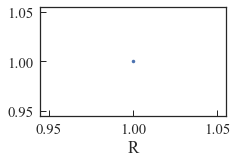

In [26]:
import matplotlib
matplotlib.rcParams['axes.labelsize']=17
matplotlib.rcParams['legend.fontsize']=16
matplotlib.rcParams['xtick.labelsize']=15
matplotlib.rcParams['ytick.labelsize']=15
plt.plot([1.],[1.],'.')
plt.xlabel('R')

In [80]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def inset_bar(ax1,im1):
    axins1 = inset_axes(ax1, width="100%", height="100%", loc='upper left',
                   bbox_to_anchor=(0.45,1-0.82,.44,.1), bbox_transform=ax1.transAxes)
    axins1.set_facecolor([1,1,1,0.7])
    [axins1.spines[k].set_visible(False) for k in axins1.spines]
    axins1.tick_params(axis='both', left='off', top='off', right='off', 
                       bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    cbaxes = inset_axes(axins1, '100%', '100%', loc = 6)
    cb=plt.colorbar(im1, cax=cbaxes, orientation="horizontal")
    plt.setp(cbaxes.get_xticklabels(), rotation=55)
    cb.ax.tick_params(labelsize=12)

In [393]:
sim_props={'m12f_lsr0':np.array([-14.9,227.9,4.9]), # From Table 4
           'm12m_lsr0':np.array([-16.2,254.7,-2.]),
           'm12i_lsr0':np.array([17.8,224.4,-3.9])}

def load_data(sim_name):
    data = pd.DataFrame(sqlutil.get('''select * from ananke.{0} 
                                        where parallax>0.5 and phot_g_mean_mag_true<17 and abs(b)>15.
                                        limit 500000'''.format(sim_name),
                       host='cappc127',user='jason_sanders',password=wsdbpassword,db='simdb',
                        asDict=True,strLength=30
                      ))
    polar = np.array([
             map(lambda xx:
                 aa_py.GalacticToPolar(
                 aa_py.EquatorialToGalactic(np.array([xx[0],xx[1],xx[2],xx[3],xx[4],xx[5]])),
                 np.concatenate((np.array([8.2,0.]),sim_props[sim_name]))),
                zip(np.deg2rad(data['ra']),np.deg2rad(data['dec']),data['dhel_true'],
                    data['radial_velocity_true'],data['pmra_true'],data['pmdec_true']))])
    for i,c in enumerate(['R','phi','z','vR','vphi','vz']):
        data[c]=polar.T[i].flatten()
    data['r']=np.sqrt(data['R']**2+data['z']**2)
    data['vr'] = (data['vR']*data['R']+data['vz']*data['z'])/data['r']
    data['vtheta'] = (-data['vR']*data['z']+data['vz']*data['R'])/data['r']
    return data

In [346]:
from plotting_general import col_norm, row_norm
from matplotlib.colors import PowerNorm

def plot_grid(data,name):
    gridsize=40
    f,a=plt.subplots(2,4,figsize=[15.,8.],sharex=True,sharey=True)
    plt.subplots_adjust(wspace=0.,hspace=0.)
    a = a.flatten()
    plt.sca(a[0]);plt.title(name,fontsize=20)
    plt.sca(a[0])
    rangex = np.array([[-2.1,0.6],[-430.,430.]])
    im=plt.hist2d(data.feh,-data.vphi,bins=gridsize,norm=LogNorm(),
             range=rangex,cmap=plt.cm.Greys);
    
    t=plt.annotate('Density',fontsize=17,xy=(0.04,0.05),va='bottom',
                   ha='left',xycoords='axes fraction')
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor="none"))
    plt.sca(a[1])
    col_norm(data.feh,-data.vphi,bins=gridsize,norm=LogNorm(),
             range=rangex,cmap=plt.cm.Greys);
    t=plt.annotate('Col. normalized density',fontsize=17,xy=(0.04,0.05),va='bottom',
                   ha='left',xycoords='axes fraction')
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor="none"))
    # plt.colorbar()
    plt.sca(a[2])
    row_norm(data.feh,-data.vphi,bins=gridsize,norm=LogNorm(),
             range=rangex,cmap=plt.cm.Greys);
    t=plt.annotate('Row normalized density',fontsize=17,xy=(0.04,0.05),va='bottom',
                   ha='left',xycoords='axes fraction')
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor="none"))
    # plt.colorbar()
    plt.sca(a[4])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=gridsize,
             extent=rangex.flatten(),edgecolors="None",vmin=40.,vmax=150.,mincnt=3,
              C=data.vR,reduce_C_function=np.nanstd,cmap=plt.cm.inferno);
    t=plt.annotate(r'$\sigma_R/\,\mathrm{km\,s}^{-1}$',fontsize=17,xy=(0.04,0.05),va='bottom',
                   ha='left',xycoords='axes fraction')
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor="none"))
    inset_bar(plt.gca(),im)

    plt.sca(a[5])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=gridsize,
             extent=rangex.flatten(),edgecolors="None",vmin=20.,vmax=100.,mincnt=3,
              C=data.vz,reduce_C_function=np.nanstd,cmap=plt.cm.inferno);
    t=plt.annotate(r'$\sigma_z/\,\mathrm{km\,s}^{-1}$',fontsize=17,xy=(0.04,0.05),va='bottom',
                   ha='left',xycoords='axes fraction')
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor="none"))
    inset_bar(plt.gca(),im)

    plt.sca(a[3])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=gridsize,
             extent=rangex.flatten(),edgecolors="None",vmin=7.6,vmax=8.8,mincnt=3,
              C=data.R,reduce_C_function=np.nanmedian,cmap=plt.cm.inferno);
    t=plt.annotate(r'$R/\,\mathrm{kpc}$',fontsize=17,xy=(0.04,0.05),va='bottom',
                   ha='left',xycoords='axes fraction')
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor="none"))
    inset_bar(plt.gca(),im)


    plt.sca(a[6])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=gridsize,
             extent=rangex.flatten(),edgecolors="None",vmin=4.,vmax=10.2,mincnt=3,
              C=np.power(10.,data.age-9.),reduce_C_function=np.nanmedian,cmap=plt.cm.inferno);
    t=plt.annotate(r'Age / $\mathrm{Gyr}$',fontsize=17,xy=(0.04,0.05),va='bottom',
                   ha='left',xycoords='axes fraction')
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor="none"))
    inset_bar(plt.gca(),im)


    plt.sca(a[7])
    im=plt.hexbin(data.feh,-data.vphi,gridsize=gridsize,
             extent=rangex.flatten(),edgecolors="None",vmin=0.2,vmax=.35,mincnt=3,
              C=data.alpha,reduce_C_function=np.nanmedian,cmap=plt.cm.inferno);
    t=plt.annotate(r'$[\alpha/\mathrm{Fe}]$',fontsize=17,xy=(0.04,0.05),va='bottom',
                   ha='left',xycoords='axes fraction')
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor="none"))
    inset_bar(plt.gca(),im)

    for i in a.flatten():
        plt.sca(i)
        plt.axvline(-0.2,color='k',ls='dashed')
        plt.axvline(-0.6,color='k',ls='dashed')
        plt.axhline(0.,color='k',ls='dashed')
#     a[2][2].axis('off')
    
    for i in range(4,8):
        plt.sca(a[i])
        plt.xlabel(r'$[\mathrm{Fe}/\mathrm{H}]$')
    for i in range(2):
        plt.sca(a[i*4])
        plt.ylabel(r'$v_\phi/\,\mathrm{km\,s}^{-1}$')
    plt.savefig(name+'.pdf',dpi=200,bbox_inches='tight')

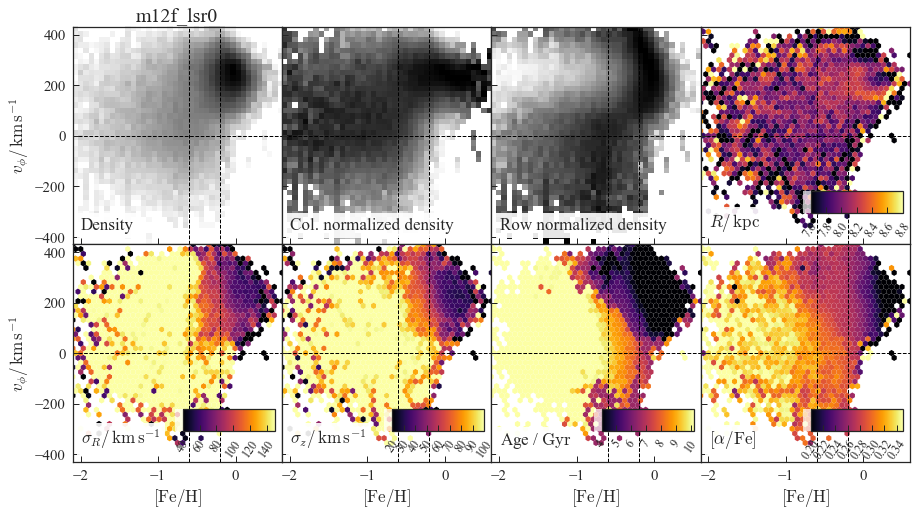

In [394]:
m12f=load_data('m12f_lsr0')
plot_grid(m12f,'m12f_lsr0')

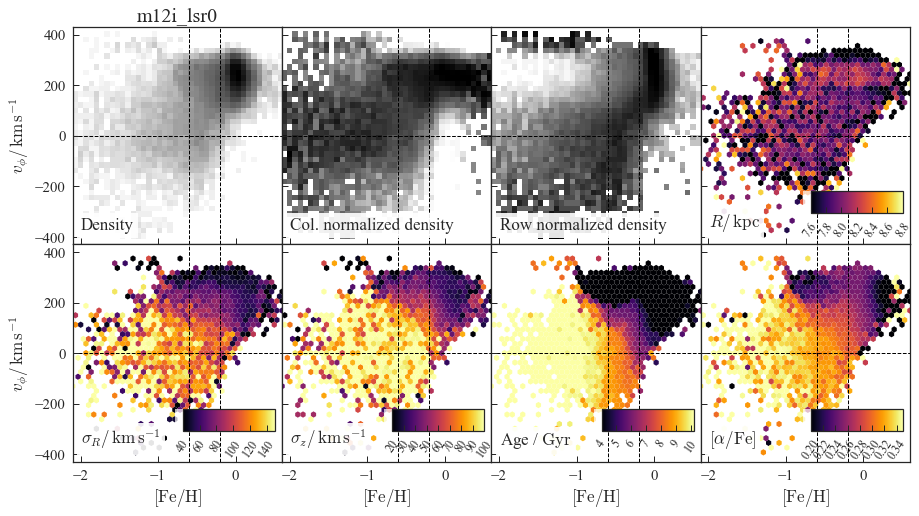

In [348]:
m12i=load_data('m12i_lsr0')
plot_grid(m12i,'m12i_lsr0')

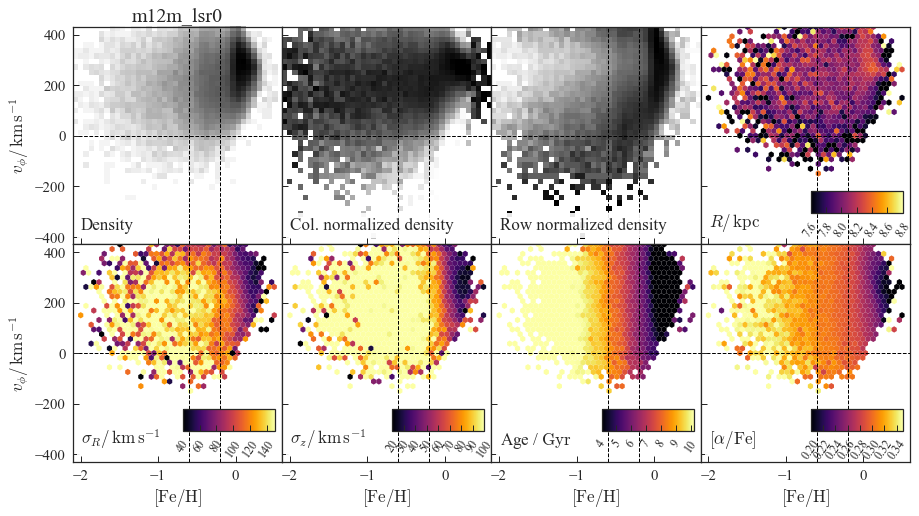

In [349]:
m12m=load_data('m12m_lsr0')
plot_grid(m12m,'m12m_lsr0')

<Figure size 576x360 with 0 Axes>

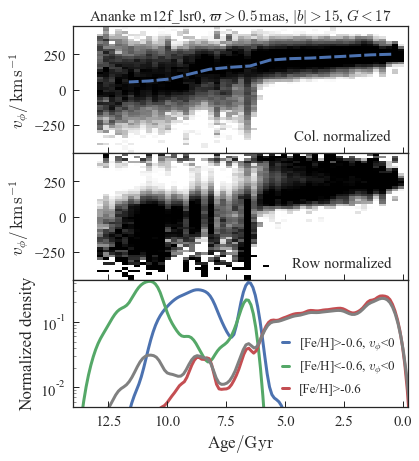

In [396]:
import seaborn as sns
from plotting_general import running_median
plt.figure(figsize=[8.,5.])
from plotting_general import row_norm
f,a=plt.subplots(3,1,figsize=[6.,7],sharex=True)
plt.subplots_adjust(hspace=0.)
plt.sca(a[0])
plt.ylabel(r'$v_\phi/\,\mathrm{km\,s}^{-1}$')
sim = m12f
fehcut=10000.
fltr = (sim['feh']<fehcut)
rr = running_median(np.power(10.,sim['age']-9.)[fltr],-sim['vphi'][fltr])
col_norm(np.power(10.,sim['age']-9.)[fltr],-sim['vphi'][fltr],bins=50,
         per=[10.,85.],norm=LogNorm(),range=[[0.,13.],[-450.,450.]]);
plt.annotate('Col. normalized', xy=(0.95,0.1), xycoords='axes fraction',ha='right',fontsize=15)
l,=plt.plot(rr[0],rr[1],lw=3)
l.set_dashes((4,1))
plt.sca(a[1])
plt.ylabel(r'$v_\phi/\,\mathrm{km\,s}^{-1}$')
fehcut=10000.
fltr = (sim['feh']<fehcut)
row_norm(np.power(10.,sim['age']-9.)[fltr],-sim['vphi'][fltr],bins=50,
         per=[10.,75.],norm=LogNorm(),range=[[0.,13.],[-450.,450.]]);
# plt.plot(rr[0],rr[1],lw=3)
# plt.sca(a[1])
# fltr = m12f['feh']>fehcut
# row_norm(-np.power(10.,sim['age']-9.)[fltr],-sim['vphi'][fltr],
#          bins=50,per=[20.,90.],norm=LogNorm(),range=[[-13.,0.],[-400.,400.]]);
fehcut=-0.6
plt.annotate('Row normalized', xy=(0.95,0.1), xycoords='axes fraction',ha='right',fontsize=15)
plt.sca(a[2])
fltr = (sim['feh']>fehcut)&(sim['vphi']>0.)#
sns.kdeplot(np.power(10.,sim['age']-9.)[fltr],lw=3,label=r'[Fe/H]>%0.1f, $v_\phi$<0'%fehcut)
fltr = (sim['feh']<fehcut)&(sim['vphi']>0.)#&(np.abs(sim['vR'])>200.)#&(np.abs(m12f['z'])<2.)
sns.kdeplot(np.power(10.,sim['age']-9.)[fltr],lw=3,label=r'[Fe/H]<%0.1f, $v_\phi$<0'%fehcut)
fltr = (sim['feh']>fehcut)#&(sim['vphi']>0.)#
sns.kdeplot(np.power(10.,sim['age']-9.)[fltr],lw=3,label='[Fe/H]>%0.1f'%fehcut)
sns.kdeplot(np.power(10.,sim['age']-9.),lw=3,label='',color='gray')
plt.legend(loc='lower right',fontsize=13,handlelength=0.5,ncol=1)
plt.ylabel('Normalized density')
plt.ylim(5e-3,)
plt.xlim(-.2,14.)
plt.gca().invert_xaxis()
plt.xlabel(r'Age$/\mathrm{Gyr}$')
plt.semilogy()
plt.sca(a[0])
plt.title(r'Ananke m12f_lsr0, $\varpi>0.5\,\mathrm{mas}$, $|b|>15$, $G<17$',fontsize=15)
plt.savefig('m12f_lsr0_vphi_age_column.pdf',bbox_inches='tight')

<Figure size 576x360 with 0 Axes>

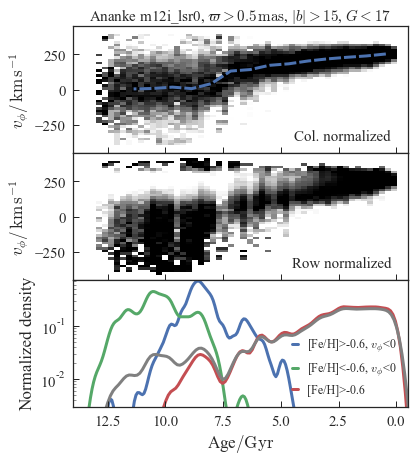

In [362]:
import seaborn as sns
from plotting_general import running_median
plt.figure(figsize=[8.,5.])
from plotting_general import row_norm
f,a=plt.subplots(3,1,figsize=[6.,7],sharex=True)
plt.subplots_adjust(hspace=0.)
plt.sca(a[0])
plt.ylabel(r'$v_\phi/\,\mathrm{km\,s}^{-1}$')
sim = m12i
fehcut=10000.
fltr = (sim['feh']<fehcut)
rr = running_median(np.power(10.,sim['age']-9.)[fltr],-sim['vphi'][fltr])
col_norm(np.power(10.,sim['age']-9.)[fltr],-sim['vphi'][fltr],bins=50,
         per=[10.,85.],norm=LogNorm(),range=[[0.,13.],[-450.,450.]]);
plt.annotate('Col. normalized', xy=(0.95,0.1), xycoords='axes fraction',ha='right',fontsize=15)
l,=plt.plot(rr[0],rr[1],lw=3)
l.set_dashes((4,1))
plt.sca(a[1])
plt.ylabel(r'$v_\phi/\,\mathrm{km\,s}^{-1}$')
fehcut=10000.
fltr = (sim['feh']<fehcut)
row_norm(np.power(10.,sim['age']-9.)[fltr],-sim['vphi'][fltr],bins=50,
         per=[10.,75.],norm=LogNorm(),range=[[0.,13.],[-450.,450.]]);
# plt.plot(rr[0],rr[1],lw=3)
# plt.sca(a[1])
# fltr = m12f['feh']>fehcut
# row_norm(-np.power(10.,sim['age']-9.)[fltr],-sim['vphi'][fltr],
#          bins=50,per=[20.,90.],norm=LogNorm(),range=[[-13.,0.],[-400.,400.]]);
fehcut=-0.6
plt.annotate('Row normalized', xy=(0.95,0.1), xycoords='axes fraction',ha='right',fontsize=15)
plt.sca(a[2])
fltr = (sim['feh']>fehcut)&(sim['vphi']>0.)#
sns.kdeplot(np.power(10.,sim['age']-9.)[fltr],lw=3,label=r'[Fe/H]>%0.1f, $v_\phi$<0'%fehcut)
fltr = (sim['feh']<fehcut)&(sim['vphi']>0.)#&(np.abs(sim['vR'])>200.)#&(np.abs(m12f['z'])<2.)
sns.kdeplot(np.power(10.,sim['age']-9.)[fltr],lw=3,label=r'[Fe/H]<%0.1f, $v_\phi$<0'%fehcut)
fltr = (sim['feh']>fehcut)#&(sim['vphi']>0.)#
sns.kdeplot(np.power(10.,sim['age']-9.)[fltr],lw=3,label=r'[Fe/H]>%0.1f'%fehcut)
sns.kdeplot(np.power(10.,sim['age']-9.),lw=3,label='',color='gray')
# sns.kdeplot(np.power(10.,sim['age']-9.),lw=3,label='Total',color='k')
plt.legend(loc='lower right',fontsize=12,handlelength=0.5)
plt.ylabel('Normalized density')
plt.ylim(3e-3,)
plt.xlim(-.5,14.)
plt.gca().invert_xaxis()
plt.xlabel(r'Age$/\mathrm{Gyr}$')
plt.semilogy()
plt.sca(a[0])
plt.title(r'Ananke m12i_lsr0, $\varpi>0.5\,\mathrm{mas}$, $|b|>15$, $G<17$',fontsize=15)
plt.savefig('m12i_lsr0_vphi_age_column.pdf',bbox_inches='tight')

In [280]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def top_cbar(lbl, cc, fontsize=18):
    ax_divider = make_axes_locatable(plt.gca())
    cax = ax_divider.append_axes('top', size='5%', pad='2%')
    cbar = plt.colorbar(cc, label=lbl, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize * 0.8)
    cbar.set_label(lbl, fontsize=fontsize)
    cax.xaxis.set_ticks_position('top')
    cax.xaxis.set_label_position('top')
    cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=50)



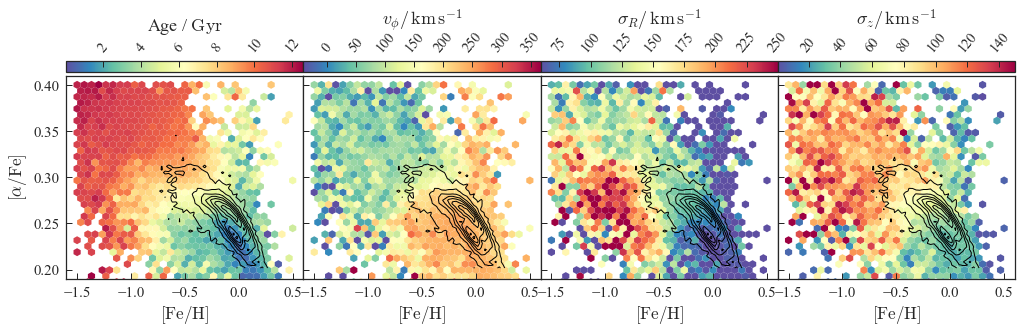

In [397]:
f,a=plt.subplots(1,4,figsize=[17.,4.],sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.)
fltr = (m12f['vphi']>-1000000.)

H,X,Y=np.histogram2d(m12f['feh'][fltr],m12f['alpha'][fltr],range=[[-1.5,0.5],[0.2,0.4]],bins=60)

plt.sca(a[0])
C=plt.hexbin(m12f['feh'][fltr],m12f['alpha'][fltr],
           gridsize=30,extent=[-1.5,0.5,0.18,0.4],mincnt=5,
           C=np.power(10.,m12f['age'][fltr]-9.),cmap=plt.cm.Spectral_r,
            edgecolors="none")
top_cbar(r'Age / $\mathrm{Gyr}$',C)

plt.sca(a[1])
C=plt.hexbin(m12f['feh'][fltr],m12f['alpha'][fltr],
           gridsize=30,extent=[-1.5,0.5,0.18,0.4],mincnt=5,
           C=-m12f['vphi'][fltr],cmap=plt.cm.Spectral_r,vmin=-40.,
            edgecolors="none")
top_cbar(r'$v_\phi / \,\mathrm{km\,s}^{-1}$',C)

plt.sca(a[2])
C=plt.hexbin(m12f['feh'][fltr],m12f['alpha'][fltr],
           gridsize=30,extent=[-1.5,0.5,0.18,0.4],mincnt=5,
           C=m12f['vR'][fltr],cmap=plt.cm.Spectral_r,reduce_C_function=np.nanstd,vmax=250.,vmin=60.,
            edgecolors="none")
top_cbar(r'$\sigma_R / \,\mathrm{km\,s}^{-1}$',C)

plt.sca(a[3])
C=plt.hexbin(m12f['feh'][fltr],m12f['alpha'][fltr],
           gridsize=30,extent=[-1.5,0.5,0.18,0.4],mincnt=5,
           C=m12f['vz'][fltr],cmap=plt.cm.Spectral_r,reduce_C_function=np.nanstd,vmax=150.,
            edgecolors="none")
top_cbar(r'$\sigma_z / \,\mathrm{km\,s}^{-1}$',C)

for ii in range(len(a)):
    plt.sca(a[ii])
    plt.contour(.5*(X[1:]+X[:-1]),.5*(Y[1:]+Y[:-1]),H.T**.5,origin='lower',colors='k')
#     xx = np.linspace(-1.5,.1)
#     l,=plt.plot(xx,-.07*xx+0.235,color='gray',lw=3)
#     l.set_dashes((4,1))
#     l,=plt.plot(xx,-.13*xx+0.253,color='gray',lw=3)
#     l.set_dashes((4,1))
    # plt.plot(m12f['feh'][fltr],m12f['alpha'][fltr],'.',ms=5)
    plt.xlim(-1.6,0.6)
    plt.ylim(0.19,0.41)
    plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.sca(a[0])
plt.ylabel(r'$[\alpha/\mathrm{Fe}]$')
plt.savefig('m12f_lsr0_alpha_fe.pdf',bbox_inches='tight')

Text(4,-1.4,'m12f_lsr0')

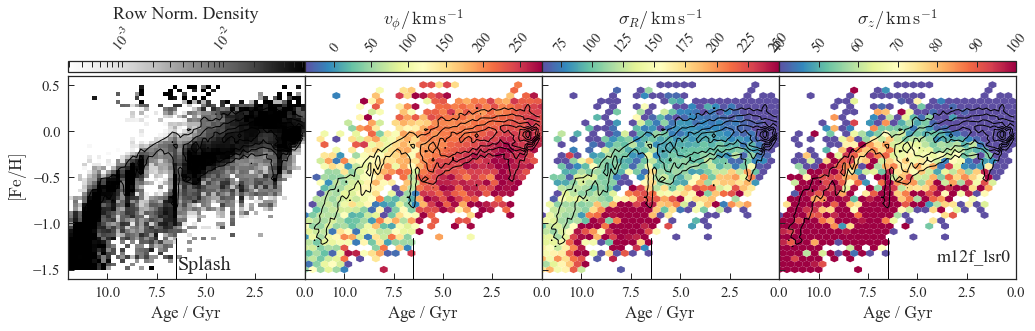

In [403]:
f,a=plt.subplots(1,4,figsize=[17.,4.],sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.)
fltr = fltr_x #(m12f['vphi']>-1000000.)
fltr = (m12f['vphi']>-1000000.)
H,X,Y=np.histogram2d(np.power(10.,m12f['age'][fltr]-9.),m12f['feh'][fltr],
                     range=[[0.,12.],[-1.5,0.5]],bins=60)
m12f['v']=np.sqrt(m12f['vR']**2+(m12f['vphi']-np.nanmedian(m12f['vphi']))**2+m12f['vz']**2)

plt.sca(a[0])
# C=plt.hexbin(np.power(10.,m12f['age'][fltr]-9.),m12f['feh'][fltr],
#            gridsize=30,extent=[0.,12.,-1.5,0.5],mincnt=5,
#            C=m12f['alpha'][fltr],cmap=plt.cm.Spectral_r,vmin=0.2,vmax=0.5,
#             edgecolors="none")
C=row_norm(np.power(10.,m12f['age']-9.)[fltr],m12f['feh'][fltr],bins=50,
         per=[5.,85.],norm=LogNorm(),range=[[0.,12.],[-1.5,0.5]]);
top_cbar(r'Row Norm. Density',C[-1])

plt.sca(a[1])
C=plt.hexbin(np.power(10.,m12f['age'][fltr]-9.),m12f['feh'][fltr],
           gridsize=30,extent=[0.,12.,-1.5,0.5],mincnt=5,
           C=-m12f['vphi'][fltr],cmap=plt.cm.Spectral_r,vmin=-40.,vmax=280.,
            edgecolors="none")
top_cbar(r'$v_\phi / \,\mathrm{km\,s}^{-1}$',C)

plt.sca(a[2])
C=plt.hexbin(np.power(10.,m12f['age'][fltr]-9.),m12f['feh'][fltr],
           gridsize=30,extent=[0.,12.,-1.5,0.5],mincnt=5,
           C=m12f['vR'][fltr],cmap=plt.cm.Spectral_r,reduce_C_function=np.nanstd,vmax=250.,vmin=60.,
            edgecolors="none")
top_cbar(r'$\sigma_R / \,\mathrm{km\,s}^{-1}$',C)

plt.sca(a[3])
C=plt.hexbin(np.power(10.,m12f['age'][fltr]-9.),m12f['feh'][fltr],
           gridsize=30,extent=[0.,12.,-1.5,0.5],mincnt=5,
           C=m12f['vz'][fltr],cmap=plt.cm.Spectral_r,
           reduce_C_function=np.nanstd,vmax=100.,vmin=40.,
           edgecolors="none")
top_cbar(r'$\sigma_z / \,\mathrm{km\,s}^{-1}$',C)

for ii in range(len(a)):
    plt.sca(a[ii])
    plt.contour(.5*(X[1:]+X[:-1]),.5*(Y[1:]+Y[:-1]),H.T**.5,origin='lower',colors='k')
#     xx = np.linspace(-1.5,.1)
#     l,=plt.plot(xx,-.07*xx+0.235,color='gray',lw=3)
#     l.set_dashes((4,1))
#     l,=plt.plot(xx,-.13*xx+0.253,color='gray',lw=3)
#     l.set_dashes((4,1))
    # plt.plot(m12f['feh'][fltr],m12f['alpha'][fltr],'.',ms=5)
    plt.ylim(-1.6,0.6)
    plt.xlim(0.,12.)
    plt.xlabel(r'Age / $\mathrm{Gyr}$')
    plt.gca().invert_xaxis()
    plt.axvline(6.5,ymax=0.2,color='k')
plt.sca(a[0])
plt.annotate('Splash',xy=(6.4,-1.5),fontsize=20)
plt.ylabel(r'$\mathrm{[Fe/H]}$')
plt.sca(a[-1])
plt.annotate('m12f_lsr0',fontsize=18,xy=(4.,-1.4))
# plt.savefig('m12f_lsr0_fe_age.pdf',bbox_inches='tight')

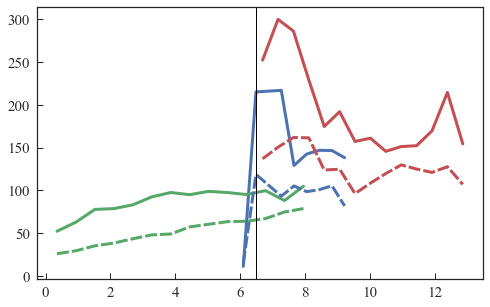

In [467]:
plt.figure(figsize=[8.,5.])
fehcut = -0.4
compt = 'vR'
Ncut=20
rr = running_median(np.power(10.,m12f['age']-9.)[(m12f['feh']>fehcut)&(m12f['vphi']>0.)],
                    m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']>0.)])
plt.plot(rr[0][rr[-1]>Ncut],.5*(rr[3]-rr[2])[rr[-1]>Ncut],lw=3)

rr = running_median(np.power(10.,m12f['age']-9.)[(m12f['feh']>fehcut)&(m12f['vphi']<-200.)],
                    m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']<-200.)])
plt.plot(rr[0][rr[-1]>Ncut],.5*(rr[3]-rr[2])[rr[-1]>Ncut],lw=3)

rr = running_median(np.power(10.,m12f['age']-9.)[(m12f['feh']<fehcut)&(m12f['vphi']>0.)],
                    m12f[compt][(m12f['feh']<fehcut)&(m12f['vphi']>0.)])
plt.plot(rr[0][rr[-1]>Ncut],.5*(rr[3]-rr[2])[rr[-1]>Ncut],lw=3)

compt = 'vz'
rr = running_median(np.power(10.,m12f['age']-9.)[(m12f['feh']>fehcut)&(m12f['vphi']>0.)],
                    m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']>0.)])
l,=plt.plot(rr[0][rr[-1]>Ncut],.5*(rr[3]-rr[2])[rr[-1]>Ncut],lw=3,color=sns.color_palette()[0])
l.set_dashes((4,1))

rr = running_median(np.power(10.,m12f['age']-9.)[(m12f['feh']>fehcut)&(m12f['vphi']<-200.)],
                    m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']<-200.)])
l,=plt.plot(rr[0][rr[-1]>Ncut],.5*(rr[3]-rr[2])[rr[-1]>Ncut],lw=3,color=sns.color_palette()[1])
l.set_dashes((4,1))

rr = running_median(np.power(10.,m12f['age']-9.)[(m12f['feh']<fehcut)&(m12f['vphi']>0.)],
                    m12f[compt][(m12f['feh']<fehcut)&(m12f['vphi']>0.)])

l,=plt.plot(rr[0][rr[-1]>Ncut],.5*(rr[3]-rr[2])[rr[-1]>Ncut],lw=3,color=sns.color_palette()[2])
l.set_dashes((4,1))

# rr = running_median(np.power(10.,m12f['age']-9.)[m12f['feh']<fehcut],m12f['v'][m12f['feh']<fehcut])
# plt.plot(rr[0],.5*(rr[3]-rr[2]))

plt.axvline(6.5,color='k')

In [525]:
compt='vR'
print(fehcut)
print('Splash',np.nanstd(m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']>0.)&(np.power(10.,m12f['age']-9.)>6.5)]))
print('Sausage',np.nanstd(m12f[compt][(m12f['feh']<fehcut)&(m12f['vphi']>0.)
                                      &(np.power(10.,m12f['age']-9.)>6.5)&(np.power(10.,m12f['age']-9.)<9.)]))
print('Thick',np.nanstd(m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']<-100.)&(m12f['vphi']>-200.)
                                      &(np.power(10.,m12f['age']-9.)>4.5)&(np.power(10.,m12f['age']-9.)<6.5)]))
print('Thin',np.nanstd(m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']<-200.)
                                      &(np.power(10.,m12f['age']-9.)<1.5)]))

compt='vz'
print('Splash',np.nanstd(m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']>0.)&(np.power(10.,m12f['age']-9.)>6.5)]))
print('Sausage',np.nanstd(m12f[compt][(m12f['feh']<fehcut)&(m12f['vphi']>0.)
                                      &(np.power(10.,m12f['age']-9.)>6.5)&(np.power(10.,m12f['age']-9.)<9.)]))
print('Thick',np.nanstd(m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']<-100.)&(m12f['vphi']>-200.)
                                      &(np.power(10.,m12f['age']-9.)>4.5)&(np.power(10.,m12f['age']-9.)<6.5)]))
print('Thin',np.nanstd(m12f[compt][(m12f['feh']>fehcut)&(m12f['vphi']<-200.)
                                      &(np.power(10.,m12f['age']-9.)<1.5)]))

-0.4
('Splash', 153.04126721370972)
('Sausage', 218.84038635912154)
('Thick', 92.90539246861677)
('Thin', 61.139609808159506)
('Splash', 101.83525215929276)
('Sausage', 129.33952239451068)
('Thick', 66.19039072819137)
('Thin', 30.49415185508088)


\begin{table}
\caption{Properties of the Gaussian mixture components}
\begin{center}
\begin{tabular}{cccccc}
Component  & fraction & $<v_{\phi}>$ & $\sigma_{\rm R}$ & $\sigma_{\phi}$  & $\sigma_{\rm Z}$\\
 & \% & km s$^{-1}$ & km s$^{-1}$ & km s$^{-1}$ & km s$^{-1}$\\
\hline
\multicolumn{6}{|c|}{$2<|z|$ (kpc)$<3$ and $-0.7<$[Fe/H]$<-0.2$} \\
\hline
``Thin'' & 25 & 220 & 31$\pm$6 & 21$\pm$4 & 26$\pm$5 \\
``Thick'' & 68 & 165 & 73$\pm$7 & 47$\pm$6 & 48$\pm$6 \\
``Splash'' & 7 & 25 & 108$\pm$19 & 54$\pm$11 & 79$\pm$21 \\
\hline
\multicolumn{6}{|c|}{$1<|z|$ (kpc)$<3$ and $-1.5<$[Fe/H]$<-1$} \\
\hline
``Thick'' & 42.5 & 160 & 73$\pm$14 & 54$\pm$9 & 64$\pm$14 \\
``Sausage'' & 50 & 0 & 175$\pm$26 & 68$\pm$15 & 82$\pm$13 \\
``Halo'' & 7.5 & 0 & 190$\pm$50 & 164$\pm$50 & 160$\pm$50 \\
\hline
\end{tabular}
\label{tab:comp}
\end{center}
\end{table}

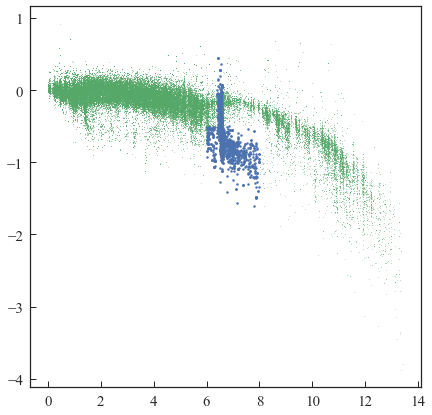

In [390]:
plt.figure(figsize=[7.,7.])
fltr_x = ~(
    ((m12f['feh']<-0.5)&(np.power(10.,m12f['age']-9.)>6.)&(np.power(10.,m12f['age']-9.)<8.))|
    (np.power(10.,m12f['age']-9.)>6.4)&(np.power(10.,m12f['age']-9.)<6.6))
plt.plot(np.power(10.,m12f['age']-9.)[~fltr_x],m12f['feh'][~fltr_x],'.',ms=5)

plt.plot(np.power(10.,m12f['age']-9.)[fltr_x],m12f['feh'][fltr_x],'.',ms=1)


Text(4,-400,'m12f_lsr0')

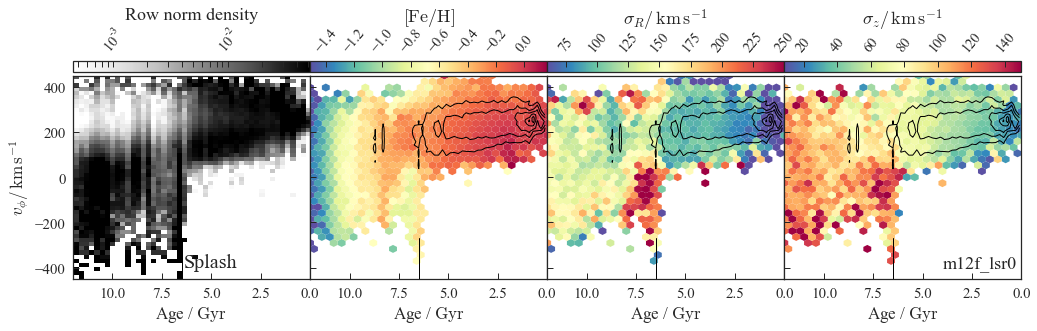

In [565]:
f,a=plt.subplots(1,4,figsize=[17.,4.],sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.)
fltr = fltr_x #(m12f['vphi']>-1000000.)
fltr = (m12f['vphi']>-1000000.)
H,X,Y=np.histogram2d(np.power(10.,m12f['age'][fltr]-9.),-m12f['vphi'][fltr],
                     range=[[0.,12.],[-450.,450.]],bins=60)

plt.sca(a[0])
# C=plt.hexbin(np.power(10.,m12f['age'][fltr]-9.),-m12f['vphi'][fltr],
#            gridsize=30,extent=[0.,12.,-450.,450.],mincnt=5,
#            C=m12f['alpha'][fltr],cmap=plt.cm.Spectral_r,vmin=0.2,vmax=0.5,
#             edgecolors="none")
C=row_norm(np.power(10.,m12f['age']-9.)[fltr],-m12f['vphi'][fltr],bins=50,
         per=[5.,85.],norm=LogNorm(),range=[[0.,13.],[-450.,450.]]);

top_cbar(r'Row norm density',C[-1])

plt.sca(a[1])
C=plt.hexbin(np.power(10.,m12f['age'][fltr]-9.),-m12f['vphi'][fltr],
           gridsize=30,extent=[0.,12.,-450.,450.],mincnt=5,
           C=m12f['feh'][fltr],cmap=plt.cm.Spectral_r,vmin=-1.51,
            edgecolors="none")
top_cbar(r'$\mathrm{[Fe/H]}$',C)

plt.sca(a[2])
C=plt.hexbin(np.power(10.,m12f['age'][fltr]-9.),-m12f['vphi'][fltr],
           gridsize=30,extent=[0.,12.,-450.,450.],mincnt=5,
           C=m12f['vR'][fltr],cmap=plt.cm.Spectral_r,reduce_C_function=np.nanstd,vmax=250.,vmin=60.,
            edgecolors="none")
top_cbar(r'$\sigma_R / \,\mathrm{km\,s}^{-1}$',C)

plt.sca(a[3])
C=plt.hexbin(np.power(10.,m12f['age'][fltr]-9.),-m12f['vphi'][fltr],
           gridsize=30,extent=[0.,12.,-450.,450.],mincnt=5,
           C=m12f['vz'][fltr],cmap=plt.cm.Spectral_r,reduce_C_function=np.nanstd,vmax=150.,
            edgecolors="none")
top_cbar(r'$\sigma_z / \,\mathrm{km\,s}^{-1}$',C)

for ii in range(len(a)):
    plt.sca(a[ii])
    if ii>0:
        plt.contour(.5*(X[1:]+X[:-1]),.5*(Y[1:]+Y[:-1]),H.T**.5,origin='lower',colors='k')
#     xx = np.linspace(-1.5,.1)
#     l,=plt.plot(xx,-.07*xx+0.235,color='gray',lw=3)
#     l.set_dashes((4,1))
#     l,=plt.plot(xx,-.13*xx+0.253,color='gray',lw=3)
#     l.set_dashes((4,1))
    # plt.plot(m12f['feh'][fltr],m12f['alpha'][fltr],'.',ms=5)
    plt.ylim(-450.,450.)
    plt.xlim(0.,12.)
    plt.xlabel(r'Age / $\mathrm{Gyr}$')
    plt.gca().invert_xaxis()
    plt.axvline(6.5,ymax=0.2,color='k')
plt.sca(a[0])
plt.annotate('Splash',xy=(6.4,-400.),fontsize=20)
plt.ylabel(r'$v_\phi/\,\mathrm{km\,s}^{-1}$')
plt.sca(a[-1])
plt.annotate('m12f_lsr0',fontsize=18,xy=(4.,-400.))
# plt.savefig('m12f_lsr0_vphi_age.pdf',bbox_inches='tight')

Text(0.5,-400,'m12f_lsr0')

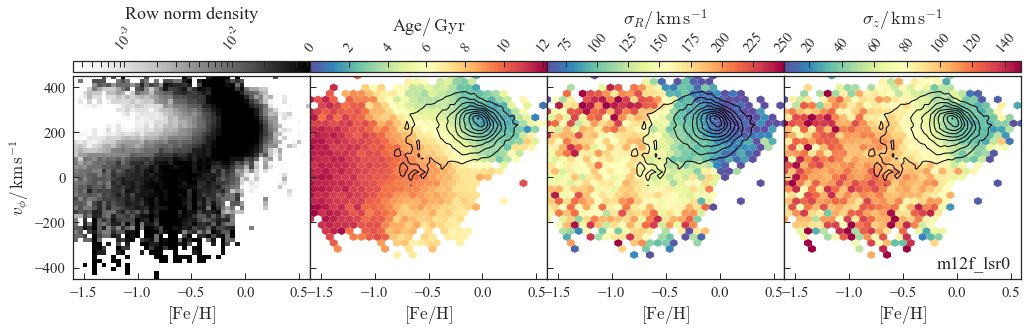

In [545]:
f,a=plt.subplots(1,4,figsize=[17.,4.],sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.)
fltr = fltr_x #(m12f['vphi']>-1000000.)
fltr = (m12f['vphi']>-1000000.)
fltrX = np.power(10.,m12f['age']-9.)>6.5
H,X,Y=np.histogram2d(m12f['feh'][fltr],-m12f['vphi'][fltr],
                     range=[[-1.6,0.6],[-450.,450.]],bins=60)

plt.sca(a[0])
# C=plt.hexbin(np.power(10.,m12f['age'][fltr]-9.),-m12f['vphi'][fltr],
#            gridsize=30,extent=[0.,12.,-450.,450.],mincnt=5,
#            C=m12f['alpha'][fltr],cmap=plt.cm.Spectral_r,vmin=0.2,vmax=0.5,
#             edgecolors="none")
C=row_norm(m12f['feh'][fltr],-m12f['vphi'][fltr],bins=50,
         per=[5.,85.],norm=LogNorm(),range=[[-1.6,0.6],[-450.,450.]]);

top_cbar(r'Row norm density',C[-1])

plt.sca(a[1])
C=plt.hexbin(m12f['feh'][fltr],-m12f['vphi'][fltr],
           gridsize=30,extent=[-1.6,0.6,-450.,450.],mincnt=5,
           C=np.power(10.,m12f['age']-9.)[fltr],cmap=plt.cm.Spectral_r,vmin=0.,
            edgecolors="none")
top_cbar(r'Age$/\,\mathrm{Gyr}$',C)

plt.sca(a[2])
C=plt.hexbin(m12f['feh'][fltr],-m12f['vphi'][fltr],
           gridsize=30,extent=[-1.6,0.6,-450.,450.],mincnt=5,
           C=m12f['vR'][fltr],cmap=plt.cm.Spectral_r,reduce_C_function=np.nanstd,vmax=250.,vmin=60.,
            edgecolors="none")
top_cbar(r'$\sigma_R / \,\mathrm{km\,s}^{-1}$',C)

plt.sca(a[3])
C=plt.hexbin(m12f['feh'][fltr],-m12f['vphi'][fltr],
           gridsize=30,extent=[-1.6,0.6,-450.,450.],mincnt=5,
           C=m12f['vz'][fltr],cmap=plt.cm.Spectral_r,reduce_C_function=np.nanstd,vmax=150.,
            edgecolors="none")
top_cbar(r'$\sigma_z / \,\mathrm{km\,s}^{-1}$',C)

for ii in range(len(a)):
    plt.sca(a[ii])
    if ii>0:
        plt.contour(.5*(X[1:]+X[:-1]),.5*(Y[1:]+Y[:-1]),H.T**.5,10,origin='lower',colors='k')
    plt.ylim(-450.,450.)
    plt.xlim(-1.6,0.6)
    plt.xlabel(r'$\mathrm{[Fe/H]}$')
#     plt.gca().invert_xaxis()
#     plt.axvline(6.5,ymax=0.2,color='k')
plt.sca(a[0])
# plt.annotate('Splash',xy=(6.4,-400.),fontsize=20)
plt.ylabel(r'$v_\phi/\,\mathrm{km\,s}^{-1}$')
plt.sca(a[-1])
plt.annotate('m12f_lsr0',fontsize=18,xy=(0.5,-400.),ha='right')
# plt.savefig('m12f_lsr0_vphi_age.pdf',bbox_inches='tight')

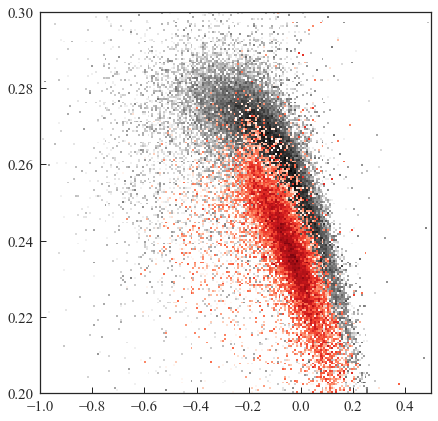

In [526]:
plt.figure(figsize=[7.,7.])
plt.hist2d(m12f['feh'][(np.power(10.,m12f['age']-9.)>0.5)&(np.power(10.,m12f['age']-9.)<6.5)],
        m12f['alpha'][(np.power(10.,m12f['age']-9.)>0.5)&(np.power(10.,m12f['age']-9.)<6.5)],bins=200,
           range=[[-1.,0.5],[0.2,0.3]],
          norm=LogNorm());

plt.hist2d(m12f['feh'][(np.power(10.,m12f['age']-9.)<1.5)&(np.power(10.,m12f['age']-9.)<6.5)],
        m12f['alpha'][(np.power(10.,m12f['age']-9.)<1.5)&(np.power(10.,m12f['age']-9.)<6.5)],bins=200,
           range=[[-1.,0.5],[0.2,0.3]],
          norm=LogNorm(),cmap=plt.cm.Reds);

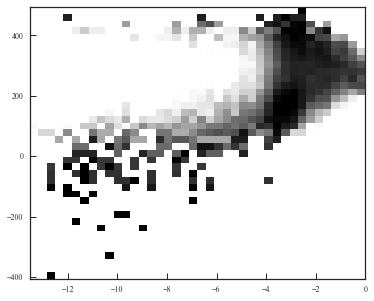

In [109]:
plt.figure(figsize=[6.,5.])
from plotting_general import row_norm
sim = m12m
fltr = (sim['alpha']<np.median(sim['alpha']))
row_norm(-np.power(10.,sim['age']-9.)[fltr],-sim['vphi'][fltr],bins=40,per=[30.,95.],norm=LogNorm());

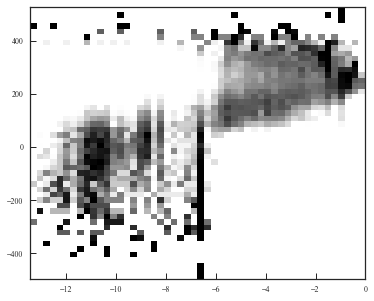

In [65]:
plt.figure(figsize=[6.,5.])
from plotting_general import row_norm
row_norm(-np.power(10.,m12f['age']-9.),
         -m12f['vphi'],bins=50,per=[30.,95.],norm=LogNorm());

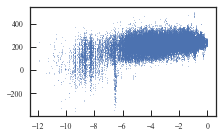

In [121]:
plt.plot(-np.power(10.,m12f['age']-9.)[m12f['feh']>-.5],
         -m12f['vphi'][m12f['feh']>-.5],'.',ms=1)

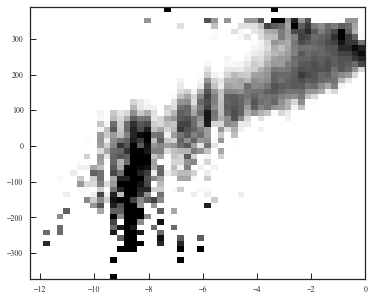

In [124]:
plt.figure(figsize=[6.,5.])
from plotting_general import row_norm
row_norm(-np.power(10.,m12i['age']-9.)[m12i['feh']>-.6],
         -m12i['vphi'][m12i['feh']>-.6],bins=50,per=[30.,95.],norm=LogNorm());

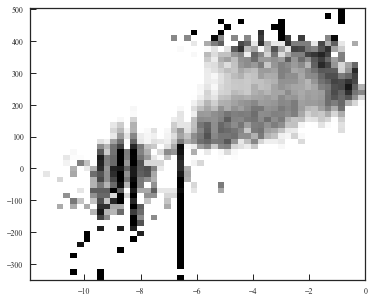

In [117]:
plt.figure(figsize=[6.,5.])
from plotting_general import row_norm
row_norm(-np.power(10.,m12f['age']-9.)[m12f['feh']>-.5],
         -m12f['vphi'][m12f['feh']>-.5],bins=50,per=[30.,95.],norm=LogNorm());

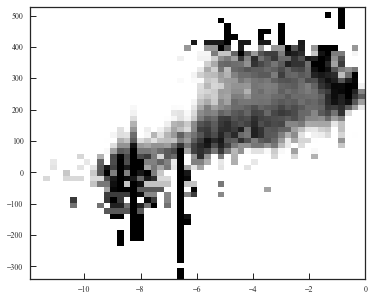

In [63]:
plt.figure(figsize=[6.,5.])
from plotting_general import row_norm
row_norm(-np.power(10.,m12f['age']-9.)[m12f['feh']>-.4],
         -m12f['vphi'][m12f['feh']>-.4],bins=50,per=[20.,90.],norm=LogNorm());

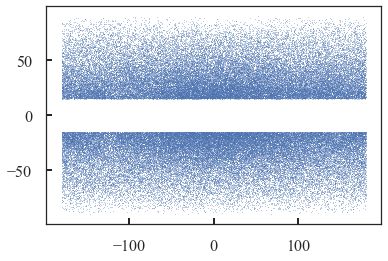

In [33]:
plt.plot(m12m['l'],m12m['b'],'.',ms=1)

## Output IDs

In [21]:
def save(data,lbl):
    data['source_id']=data['source_id'].astype('int64')
    data[['source_id','parentid']].to_csv('/data/jls/GaiaDR2/ananke/'+lbl+'.csv.gz',
                                          compression='gzip',index=False)

In [24]:
save(m12f,'m12f_index')
save(m12i,'m12i_index')
save(m12m,'m12m_index')

In [172]:
id_file_m12f = pd.read_csv('/data/jls/id_list.csv.gz')

In [174]:
data = load_data('m12f_lsr0')

In [178]:
indices = id_file_m12f.values[data['parentid']].flatten()

In [185]:
np.max(indices)

92449141

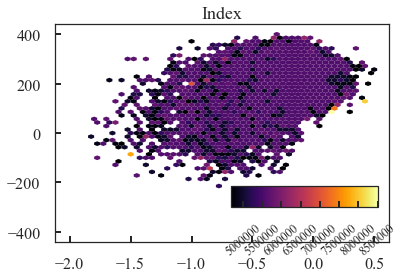

In [189]:
im=plt.hexbin(data.feh,-data.vphi,gridsize=50,
             extent=[-2.,0.5,-400.,400.],edgecolors="None",mincnt=3,
              C=data.parentid,reduce_C_function=np.nanmedian,cmap=plt.cm.inferno);
plt.title('Index')
inset_bar(plt.gca(),im)

In [371]:
m12f.loc[0,'a0']=1.

In [372]:
m12f['a0']

0        1.000000e+00
1        4.535440e-02
2        3.104280e-06
3        3.875390e-02
4        1.588780e-02
5        3.414250e-03
6        2.388890e-02
7        3.453890e-02
8        5.507540e-02
9        1.318640e-01
             ...     
99990    2.248380e-02
99991    8.667480e-05
99992    1.376570e-04
99993    4.988880e-03
99994    2.005970e-02
99995    3.167620e-03
99996    1.861550e-03
99997    3.326190e-08
99998    1.150160e-03
99999    4.150550e-02
Name: a0, Length: 100000, dtype: float32

## Inside-out

In [572]:
sim_props={'m12f_lsr0':np.array([-14.9,227.9,4.9]), # From Table 4
           'm12m_lsr0':np.array([-16.2,254.7,-2.]),
           'm12i_lsr0':np.array([17.8,224.4,-3.9])}

def load_data_EX(sim_name):
    data = pd.DataFrame(sqlutil.get('''select * from ananke.{0} 
                                        where phot_g_mean_mag_true<19 and abs(b)>15.
                                        limit 100000'''.format(sim_name),
                       host='cappc127',user='jason_sanders',password=wsdbpassword,db='simdb',
                        asDict=True,strLength=30
                      ))
    polar = np.array([
             map(lambda xx:
                 aa_py.GalacticToPolar(
                 aa_py.EquatorialToGalactic(np.array([xx[0],xx[1],xx[2],xx[3],xx[4],xx[5]])),
                 np.concatenate((np.array([8.2,0.]),sim_props[sim_name]))),
                zip(np.deg2rad(data['ra']),np.deg2rad(data['dec']),data['dhel_true'],
                    data['radial_velocity_true'],data['pmra_true'],data['pmdec_true']))])
    for i,c in enumerate(['R','phi','z','vR','vphi','vz']):
        data[c]=polar.T[i].flatten()
    data['r']=np.sqrt(data['R']**2+data['z']**2)
    data['vr'] = (data['vR']*data['R']+data['vz']*data['z'])/data['r']
    data['vtheta'] = (-data['vR']*data['z']+data['vz']*data['R'])/data['r']
    return data

m12f_N = load_data_EX('m12f_lsr0')

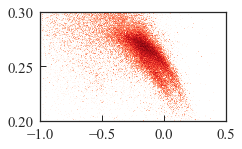

In [592]:
plt.hist2d(m12f_N['feh']#[(np.power(10.,m12f_N['age']-9.)<1.5)&(m12f_N['R']<7.)]
           ,m12f_N['alpha']#[(np.power(10.,m12f_N['age']-9.)<1.5)&(m12f_N['R']<7.)]
           ,bins=200,
           range=[[-1.,0.5],[0.2,0.3]],
           norm=LogNorm(),cmap=plt.cm.Reds);

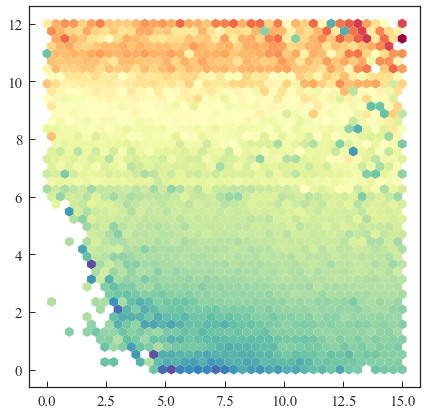

In [590]:
plt.figure(figsize=[7.,7.])
plt.hexbin(m12f_N['R'],np.power(10.,m12f_N['age']-9.),extent=[0.,15.,0.,12.],
          C=m12f_N['alpha'],vmin=0.2,vmax=0.4,cmap=plt.cm.Spectral_r,gridsize=40,edgecolors="none");